In [1]:
import pandas as pd
import astropy.units as u
from AntennaUtils import *  
import warnings
from datetime import datetime
# Imprimimos estadísticas resumidas del DataFrame final
pd.set_option('display.float_format', '{:.10f}'.format)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


e:\CODING\RT-32-SunImage\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

# RT32 location (Ventspils, Latvia)
rt32_antenna = RT32()


rt32_antenna.set_location(latitude=57.5535171694, longitude=21.8545525000, elevation=20)

# Define constants
year = 2025
month = 5
day = 8
hour_start = 9
minute_start = 15


temperature = u.Quantity(20.0, unit=u.deg_C)
pressure = u.Quantity(1013.25, unit=u.hPa)
relative_humidity = u.Quantity(60.0, unit=u.percent)
obswl =u.Quantity(50000, unit=u.nm) 

weather = Weather(temperature, pressure, relative_humidity, obswl)

observation_datetime = datetime(year, month, day, hour_start, minute_start)
observation = SpiralSunObservation(weather, rt32_antenna, observation_datetime)

fit_file_path = "real_data/lnsp4_5ch_250508_091400_101010.fit"
ptf_file_path = "real_data/sun_scan_250508_0915.ptf"

#CONSTANTS
hdu_number = 1  # Number of the extension containing the binary table
path = ''

#DATA CALCULATION:
az_anten, el_anten , az_sun , el_sun , xx1 , yy1, utc = observation.calculatePositions()

# az_anten, el_anten , az_sun , el_sun , xx1 , yy1, utc = observation.calculatePositionsFromPTF(ptf_file_path)

observation.generateFile(path, az_anten , el_anten , utc)  

print('-------------------------------------------------------------')
print('Start processing the FITS file:', fit_file_path)
# Converts the binary table to a Pandas DataFrame
data_df = bintable_to_pandas(fit_file_path, hdu_number)        

print('Processing the data...')
band_data_dfs = processData(data_df)

sunPositionDf = pd.DataFrame({'UTC': utc,'SunX': xx1, 'SunY': yy1  })

print('Getting final processed data...')
processed_dfs = getFinalProcessedData(observation , sunPositionDf,band_data_dfs)


SpiralSunObservation 2025-05-08T09:15:00
-------------------------------------------------------------
Saved:  sun_scan_250508_0915.ptf    3300   points
-------------------------------------------------------------
Start processing the FITS file: real_data/lnsp4_5ch_250508_091400_101010.fit
Processing the data...
Getting final processed data...


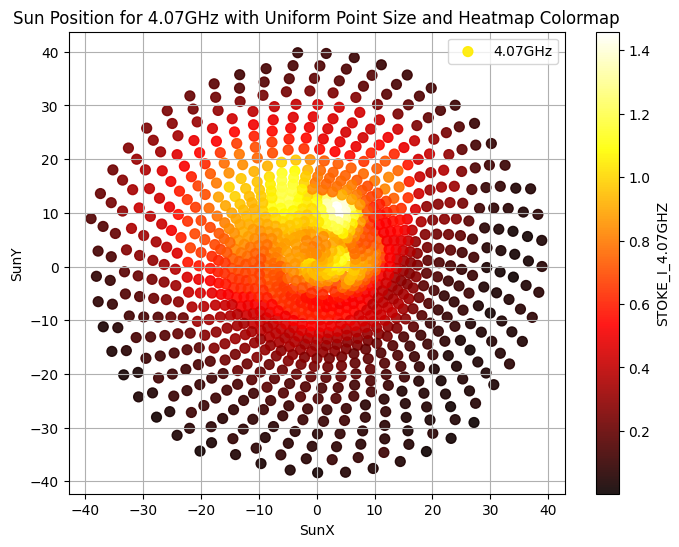

In [6]:

import matplotlib.pyplot as plt

# Extract data for 4.07GHz
data_4_07GHz = processed_dfs['4.07GHZ']

# Plot SunX vs SunY for 4.07GHz with uniform point size and red colormap
plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_4_07GHz['SunX'], data_4_07GHz['SunY'], 
                      c=data_4_07GHz['STOKE_I_4.07GHZ'], 
                      s=50,  # Uniform point size
                      cmap='hot', alpha=0.9, label='4.07GHz')
plt.colorbar(scatter, label='STOKE_I_4.07GHZ')
plt.xlabel('SunX')
plt.ylabel('SunY')
plt.title('Sun Position for 4.07GHz with Uniform Point Size and Heatmap Colormap')
plt.legend()
plt.grid()
plt.show()

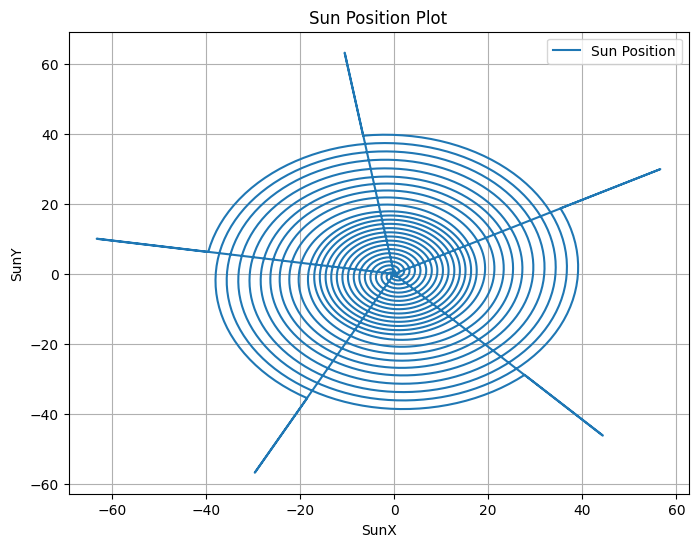

In [7]:
import matplotlib.pyplot as plt



plt.figure(figsize=(8, 6))
plt.plot(sunPositionDf['SunX'], sunPositionDf['SunY'], label='Sun Position')
plt.xlabel('SunX')
plt.ylabel('SunY')
plt.title('Sun Position Plot')
plt.legend()
plt.grid()
plt.show()